## Demonstrate Python Version of Kernels 

In this assignment, we'll demonstrate a Python version of kernels, soft-margin, and using CVXOPT to solve a quadratic programming problem. you can learn more about Quadratic Programming in Python with the [CVXOPT Quadratic Programming Docs](https://cvxopt.org/userguide/coneprog.html#quadratic-programming). You can also check out this [CVXOPT Quadratic Programming example.](https://cvxopt.org/examples/tutorial/qp.html)



In [ ]:
# Do not change anything in this cell.
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Do not change anything in this cell
import cvxopt
import cvxopt.solvers
import pylab as pl

In [ ]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)# Return the linear kernel

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p # Return the polynomial kernel

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2))) # Return the gaussian kernel

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        # Initialize the variables 
        # Handle the case where C might not be None (for soft margin classifier)
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        """
        that will fit the data
        X: data
        y: target
        """
        n_samples = X.shape[0]
        n_features = X.shape[1]
        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        P = np.zeros((n_samples, n_samples))
        # Hint: Initialize with 0s
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])
                P[i, j] = K[i, j] * y[i] * y[j]

        # Variables required to solve the equation.
        # P = k(xi, xj) * yi * yj
        P = cvxopt.matrix(P)
        # constant matrix for a
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        # Ax=b. A = y.T
        A = cvxopt.matrix(y).trans()
        # zero matrix, [0]
        b = cvxopt.matrix(0.0)

        # Values if its a soft margin or hard margin classifier
        if self.C is None:
            # Gx <= h, which is -a_i <= 0, every a >= 0
            # G: diagonal matrix of -1
            G = cvxopt.matrix(-1 * np.identity(n_samples))
            # h: all zeros
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            # Gx <= h, which is 0<=a_i<= c
            # separate into two conditions
            # cond 1: -a_i >= 0 and cond 2: a_i <= c
            cond_1_G = -1 * np.identity(n_samples)
            cond_2_G = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((cond_1_G, cond_2_G)))
            cond_1_H = np.zeros(n_samples)
            cond_2_H = self.C * np.ones(n_samples)
            h = cvxopt.matrix(np.append(cond_1_H, cond_2_H))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        # Lagrange multipliers (get alpha)
        a = np.array(solution['x'])[:, 0]

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        # index of a, where a_i > 1e-5, practically non zero
        ind = np.where(a > 1e-5)[0]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        #  Find the Intercept
        self.b = 0
        for n in range(len(self.a)):
            # b = y-a*y*kernel(xi, xj)
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)

        # Find the Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                # w = sum(a_i * y_i * x_i)
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        """
        Function that helps predictions to get to predic the outcome
        X: dataset
        returns predictions + bias
        """
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    # multiply with every support vectors
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s + self.b
            return y_predict

    def predict(self, X):
        # Return the sign of prediction using np.sign and project method.
        return np.sign(self.project(X))

In [ ]:
# Do not change anything in this cell. Please go through the data generation functions
# to get a better understanding of kernels and its effects.
def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()

def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(polynomial_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=1000.1)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

     pcost       dcost       gap    pres   dres
 0: -1.8513e+01 -3.5641e+01  6e+02  2e+01  2e+00
 1: -2.4861e+01 -2.0523e+01  2e+02  9e+00  7e-01
 2: -7.5128e+01 -5.0963e+01  2e+02  8e+00  6e-01
 3: -1.4017e+02 -6.2706e+01  2e+02  5e+00  4e-01
 4: -5.8043e+00 -1.0540e+01  2e+01  2e-01  2e-02
 5: -7.1894e+00 -8.1681e+00  2e+00  2e-02  2e-03
 6: -8.0286e+00 -8.0389e+00  3e-02  2e-04  2e-05
 7: -8.0373e+00 -8.0374e+00  3e-04  2e-06  2e-07
 8: -8.0374e+00 -8.0374e+00  3e-06  2e-08  2e-09
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


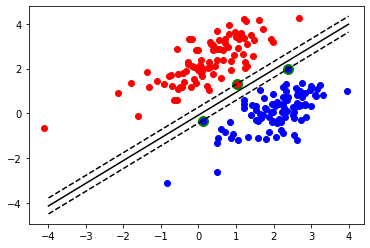

In [ ]:
test_linear()

     pcost       dcost       gap    pres   dres
 0: -4.3997e+01 -1.0351e+02  1e+03  4e+01  2e+00
 1: -6.4599e+01 -7.9772e+01  7e+02  2e+01  1e+00
 2: -1.8432e+01 -6.1849e+00  2e+02  5e+00  3e-01
 3: -5.0214e-01 -7.0470e-01  7e+00  2e-01  1e-02
 4: -2.7997e-02 -4.9533e-01  2e+00  3e-02  2e-03
 5: -7.4266e-02 -3.1713e-01  5e-01  8e-03  5e-04
 6: -1.2299e-01 -2.2400e-01  2e-01  3e-03  2e-04
 7: -1.5288e-01 -2.1042e-01  1e-01  1e-03  7e-05
 8: -1.7372e-01 -1.9335e-01  3e-02  3e-04  2e-05
 9: -1.7655e-01 -1.9115e-01  2e-02  1e-04  8e-06
10: -1.8179e-01 -1.8940e-01  1e-02  6e-05  4e-06
11: -1.8534e-01 -1.8838e-01  3e-03  1e-16  3e-14
12: -1.8788e-01 -1.8813e-01  2e-04  1e-16  3e-14
13: -1.8811e-01 -1.8811e-01  3e-06  1e-16  2e-14
14: -1.8811e-01 -1.8811e-01  3e-08  6e-17  3e-14
Optimal solution found.
9 support vectors out of 180 points
20 out of 20 predictions correct


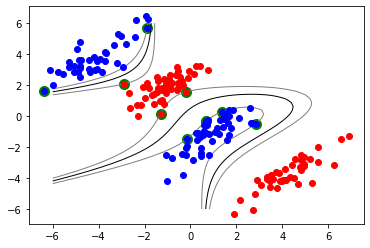

In [ ]:
test_non_linear()

     pcost       dcost       gap    pres   dres
 0:  1.3712e+05 -8.6040e+07  2e+08  5e-01  7e-12
 1:  3.8098e+05 -1.6318e+07  3e+07  5e-02  1e-11
 2:  3.4152e+05 -3.2650e+06  5e+06  8e-03  4e-12
 3:  1.0777e+05 -6.0281e+05  8e+05  9e-04  4e-12
 4:  4.9361e+03 -8.2802e+04  9e+04  2e-05  5e-12
 5: -4.0641e+03 -3.1463e+04  3e+04  5e-06  5e-12
 6: -5.2024e+03 -2.6240e+04  2e+04  3e-06  4e-12
 7: -5.7836e+03 -2.2701e+04  2e+04  2e-06  4e-12
 8: -6.2095e+03 -1.1438e+04  5e+03  4e-07  5e-12
 9: -6.7212e+03 -1.1856e+04  5e+03  4e-07  5e-12
10: -7.8323e+03 -1.0064e+04  2e+03  1e-07  5e-12
11: -8.0129e+03 -9.6563e+03  2e+03  7e-08  5e-12
12: -8.1486e+03 -9.2610e+03  1e+03  1e-09  6e-12
13: -8.2213e+03 -9.0290e+03  8e+02  7e-10  5e-12
14: -8.5807e+03 -8.6194e+03  4e+01  2e-12  6e-12
15: -8.5985e+03 -8.5989e+03  4e-01  9e-13  5e-12
16: -8.5987e+03 -8.5987e+03  4e-03  7e-13  6e-12
Optimal solution found.
12 support vectors out of 180 points
20 out of 20 predictions correct


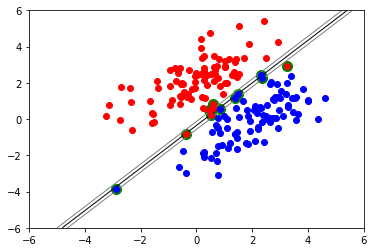

In [ ]:
test_soft()